# Moscow House Pricing EDA

## 1. Loading data

In [63]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Reading CSV-files
apartments_train = pd.read_csv("data/apartments_train.csv")
buildings_train = pd.read_csv("data/buildings_train.csv")
apartments_test = pd.read_csv("data/apartments_test.csv")
buildings_test = pd.read_csv("data/buildings_test.csv")

# Merge Tables: Apartments and Buildings
train_df = apartments_train.merge(buildings_train, left_on='building_id', right_on='id', suffixes=('', '_r')).sort_values('id').set_index('id')
test_df = apartments_test.merge(buildings_test, left_on='building_id', right_on='id', suffixes=('', '_r')).sort_values('id').set_index('id')

# Splitting data into train and validation set
X_train, X_val, y_train, y_val = train_test_split(train_df, train_df.price, train_size=0.999, random_state=0)
X_train.drop(['building_id', 'street', 'price', 'id_r', 'address'], axis=1, inplace=True)
X_val.drop(['building_id', 'street', 'price', 'id_r', 'address'], axis=1, inplace=True)
X_test = test_df.drop(['building_id', 'id_r', 'street', 'address'], axis=1)

## 2. Analyze Feature Distributions

Log-transform target variable:

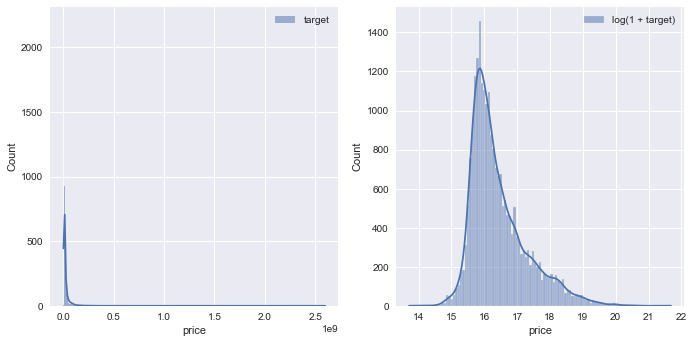

In [66]:
import seaborn as sns

fig, (ax1, ax2) = plt.subplots(1, 2)
plt.subplots_adjust(left=-0.2)

trans_data = pd.DataFrame(np.log1p(train_df["price"]), columns=["price"])

sns.histplot(train_df, x="price", label="target", kde=True, ax=ax1)
sns.histplot(trans_data, x="price", label="log(1 + target)", kde=True, ax=ax2)

ax1.legend()
ax2.legend()

## 3. Analyze Missing Values and Find Best Imputation

Plot how missing values are scattered along the dataset (White segments represent missing values):

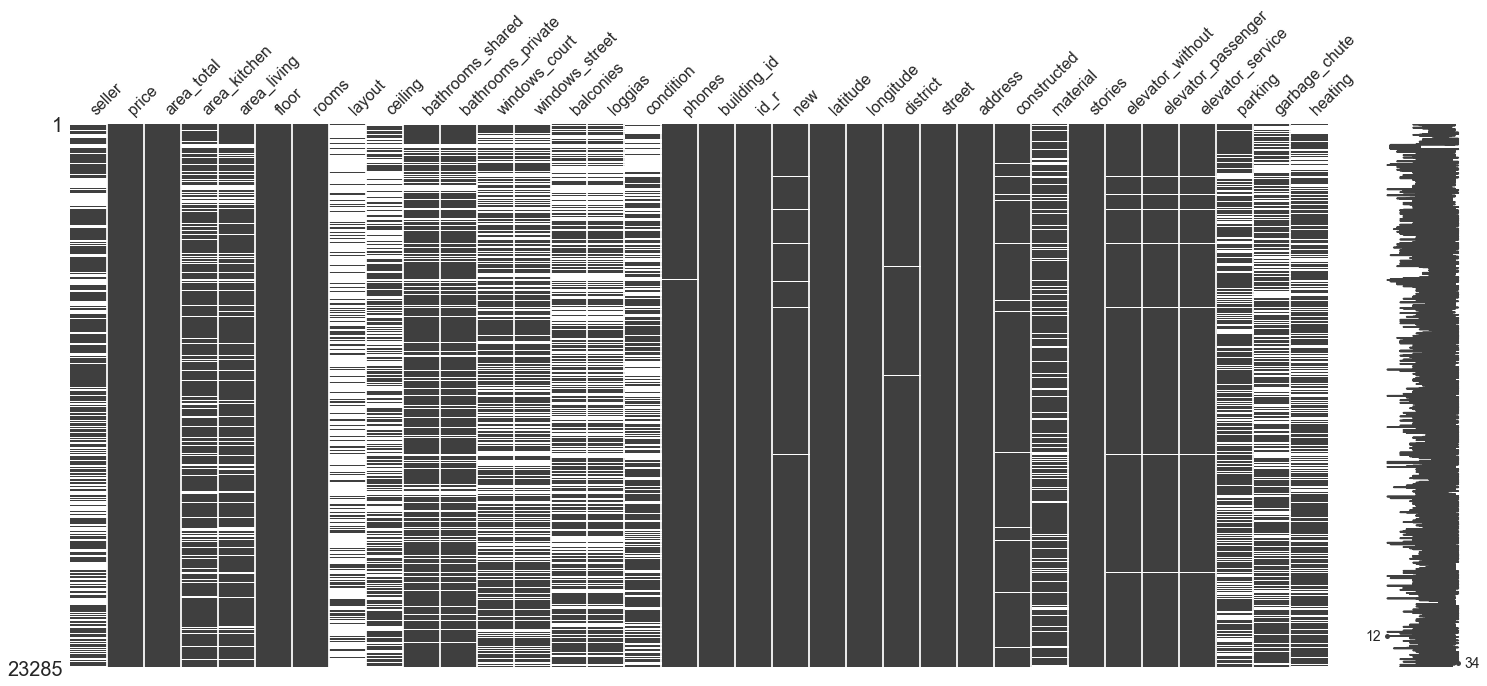

In [39]:
import missingno as msno
msno.matrix(train_df);

Plotting correlations between missing values to find out correlation between missing values:

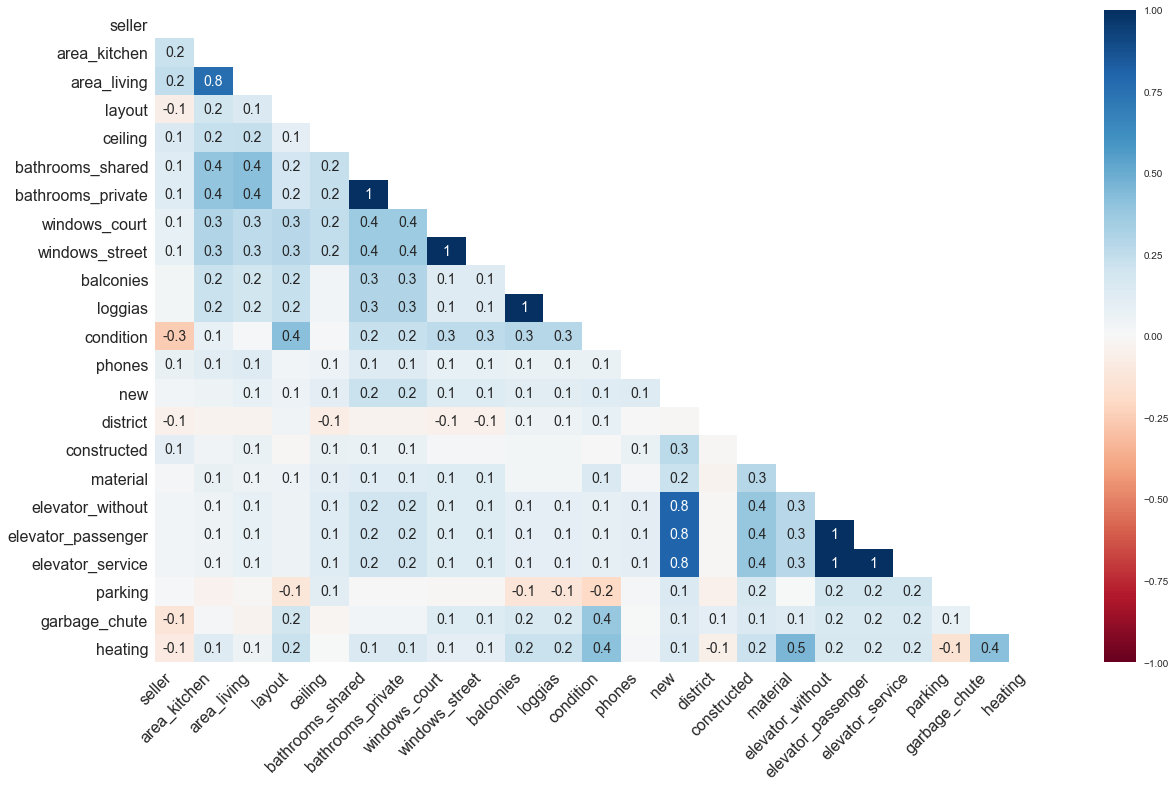

In [40]:
msno.heatmap(train_df);

Comparing the following imputers on the whole data set:
- SimpleImputer (numerical features -> mean, catagorical features -> most_frequent)
- KNN-Imputer (k=2, k=3, k=5, k=7, k=9)
- IterativeImputer (BayesianRidge, ExtraTreeRegressor)

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.linear_model import BayesianRidge
from sklearn.metrics import mean_squared_log_error, make_scorer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.compose import TransformedTargetRegressor, ColumnTransformer

from catboost import CatBoostRegressor

In [8]:
def rmsle(y_true, y_pred):
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

model_cat = CatBoostRegressor(iterations=2000, depth=7, learning_rate=0.15, l2_leaf_reg=0.45, silent=True)
trans_cat = TransformedTargetRegressor(regressor=model_cat, func=np.log1p, inverse_func=np.expm1)

np.random.seed(42069)

# Simple Imputer
categorical_columns = ["seller", "layout", "condition", "district", "material", "parking", "heating"]
numerical_columns = X_train.drop(categorical_columns, axis=1).columns

imputer = ColumnTransformer(
    transformers=[
        ('num', SimpleImputer(strategy="mean"), numerical_columns),
        ('cat', SimpleImputer(strategy="most_frequent"), categorical_columns)
])

pipe = make_pipeline(imputer, trans_cat)
print("Running SimpleImputer")
si_scores = pd.DataFrame(cross_val_score(pipe, X_train, y_train, scoring=make_scorer(rmsle)), columns="Simple Imputer")


# Iterative Imputer
ii_scores = pd.DataFrame()
for estimator in [BayesianRidge()]:
    print("Testing IterativeImputer", estimator.__class__.__name__)
    pipe = make_pipeline(IterativeImputer(estimator=estimator), trans_cat)
    ii_scores[estimator.__class__.__name__] = cross_val_score(pipe, X_train, y_train, scoring=make_scorer(rmsle))


# KNN Imputer
knn_scores = pd.DataFrame()
n_neighbors = [2, 3, 5, 7, 9]
for k in n_neighbors:
    print("Running KNNImputer", k)
    pipe = make_pipeline(KNNImputer(n_neighbors=k), trans_cat)
    knn_scores[f"KNN(k = {k})"] = cross_val_score(pipe, X_train, y_train, scoring=make_scorer(rmsle))


# Combine scores into single dataframe
final_scores = pd.concat([ii_scores, knn_scores, si_scores], axis=1, keys=["iterative_imputer", "knn_imputer", "simple_imputer"])

Testing IterativeImputer BayesianRidge


C:\Users\kiril\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\impute\_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\kiril\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\impute\_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\kiril\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\impute\_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\kiril\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\impute\_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\kiril\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\impute\_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


Running KNNImputer 2
Running KNNImputer 3
Running KNNImputer 5
Running KNNImputer 7
Running KNNImputer 9


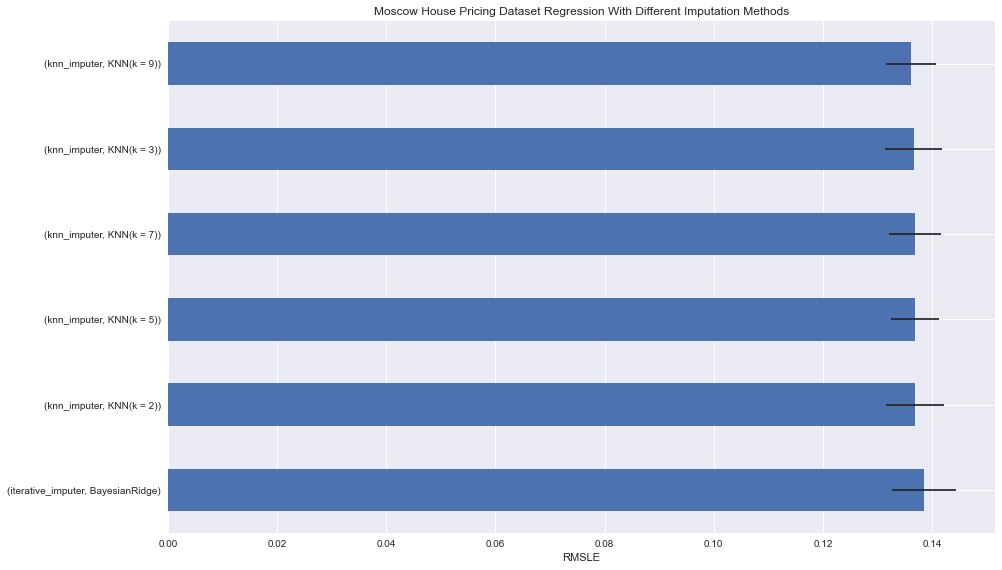

In [42]:
fig, ax = plt.subplots(figsize=(14, 8))

means, errors = final_scores.mean().sort_values(ascending=False), final_scores.std()
means.plot.barh(xerr=errors, ax=ax)

ax.set_title("Moscow House Pricing Dataset Regression With Different Imputation Methods")
ax.set_xlabel("RMSLE")
ax.set_yticks(np.arange(means.shape[0]))
plt.tight_layout(pad=1)